# Chest Xray Pneumonia Classification

<img src="images/chest_xray.jpeg" alt="Drawing" style="width: 1000px;height:300px;float: left;"/>

## Summary
This project used nearly 6,000 pediatric xray images from the Guangzhou Women and Children’s Medical Center to develop an image classification model that can accurately identify the presence of pneumonia. The model has been developed for a local hospital that is looking to increase their efficiency and accuracy in diagnosing pneumonia in order to improve patient experience and outcome. The data was processed using ImageDataGenerator from the keras library, and then split into training, validation, and test datasets. The training set was further split into a smaller training set for faster processing on initial modeling iterations. The project uses convolutional neural networks from the keras library. Over several iterations, the model complexity of the model architecture is adjusted through the number of layers, the number of convolutional filters, and the number of neurons. Additionally, several regularization techniques are applied to reduce overfitting. The final CNN model showed a 96% accuracy in detecting pneumonia.

## Business Understanding
A local hospital is looking to improve the efficiency and accuracy in which they diagnose pediatric pneumonia. By doing so, they will be able to decrease diagnostic error and limit patient wait times. This will improve overall patient experience. 

## Data Understanding
The data for this project comes from the Guangzhou Women and Children’s Medical Center. It consists of 5,956 chest x-ray images of patients ages 1-5. The dataset has a class imbalance of 73% negative and 27% positive.

In [1]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import random
from skimage.segmentation import mark_boundaries
from lime import lime_image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import talos

In [2]:
train_folder = 'chest_xray/train/'
test_folder = 'chest_xray/test/'
val_folder = 'chest_xray/val/'

In [3]:
# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, batch_size=624) 

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, batch_size=16)

# get all the data in the directory split/train, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [4]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [5]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


## Data Preparation
The ratio of the default train, test, and validation dataset sizes is not ideal, so the data is combined and then split into new train, test, and validation datasets. The training dataset if further split so that the initial models can be trained on a smaller dataset that will process faster. Also the data is reshaped to 2 dimensions so that a dense neural network architecture can be run using the data.

In [9]:
#reshape label data
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [10]:
#combine three original datasets into one for data and labels
X = np.concatenate((train_images, test_images, val_images))
y = np.concatenate((train_y, test_y, val_y))

In [11]:
X.shape

(5856, 256, 256, 3)

In [12]:
#intial split of data into traiing and test sets
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=879, 
                                                        random_state=42)

In [13]:
#second split of data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size=879,
                                                 random_state=42)

In [17]:
#third split of data into smaller training set
X_train_sub, x, y_train_sub, y = train_test_split(X_train, y_train, test_size=3545,
                                                 random_state=42)
X_val_sub, x1, y_val_sub, y1 = train_test_split(X_val, y_val, test_size=761,
                                               random_state=42)

In [18]:
#new dataset breakdown
print("Full Number of Training Samples: ", y_train.shape[0])
print("SubSet Number of Training Samples: ", y_train_sub.shape[0])
print("Full Number of Validation Samples: ", y_val.shape[0])
print("Subset Number of Validation Samples: ", y_val_sub.shape[0])
print("Number of Test Samples: ", y_test.shape[0])

Full Number of Training Samples:  4098
SubSet Number of Training Samples:  553
Full Number of Validation Samples:  879
Subset Number of Validation Samples:  118
Number of Test Samples:  879


In [19]:
#reshape image data into 2d for use in DNN
full_train_img = X_train.reshape(X_train.shape[0], -1)
sub_train_img = X_train_sub.reshape(X_train_sub.shape[0], -1)
test_img = X_test.reshape(X_test.shape[0], -1)
val_img = X_val.reshape(X_val.shape[0], -1)

print(full_train_img.shape)
print(sub_train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4098, 196608)
(553, 196608)
(879, 196608)
(879, 196608)


## Baseline Model

In [210]:
baseline_dnn_model = models.Sequential()
baseline_dnn_model.add(layers.Dense(10, activation='relu', input_shape=(196608,))) # 1 hidden layer
baseline_dnn_model.add(layers.Dense(5, activation='relu'))
baseline_dnn_model.add(layers.Dense(1, activation='sigmoid'))

In [211]:
baseline_dnn_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [213]:
baseline_dnn_history = baseline_dnn_model.fit(sub_train_img,
                    y_train_sub,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, y_val))

Epoch 1/50
65/65 [==============================] - 5s 73ms/step - loss: 0.7180 - accuracy: 0.7462 - val_loss: 0.6473 - val_accuracy: 0.7081
Epoch 2/50
65/65 [==============================] - 2s 23ms/step - loss: 0.6199 - accuracy: 0.7467 - val_loss: 0.6225 - val_accuracy: 0.7081
Epoch 3/50
65/65 [==============================] - 1s 20ms/step - loss: 0.5950 - accuracy: 0.7467 - val_loss: 0.6108 - val_accuracy: 0.7081
Epoch 4/50
65/65 [==============================] - 1s 20ms/step - loss: 0.5815 - accuracy: 0.7467 - val_loss: 0.6064 - val_accuracy: 0.7081
Epoch 5/50
65/65 [==============================] - 1s 20ms/step - loss: 0.5753 - accuracy: 0.7467 - val_loss: 0.6042 - val_accuracy: 0.7081
Epoch 6/50
65/65 [==============================] - 1s 20ms/step - loss: 0.5709 - accuracy: 0.7467 - val_loss: 0.6039 - val_accuracy: 0.7081
Epoch 7/50
65/65 [==============================] - 1s 20ms/step - loss: 0.5685 - accuracy: 0.7467 - val_loss: 0.6040 - val_accuracy: 0.7081
Epoch 8/50
65

In [31]:
#define function to plot accuracy and loss of model
def plot_training(history):
    history_dict = history.history
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    acc_values = history_dict['accuracy'] 
    val_acc_values = history_dict['val_accuracy']
    
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
   
    epochs = range(1, len(acc_values) + 1)
    ax[0].plot(epochs, acc_values, label='Training acc')
    ax[0].plot(epochs, val_acc_values, label='Validation acc')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend();
    
    ax[1].plot(epochs, loss_values, label='Training loss')
    ax[1].plot(epochs, val_loss_values, label='Validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend();
    
    print("Final Training Accuracy:", acc_values[-1])
    print("Final Validation Accuracy:", val_acc_values[-1])

Final Training Accuracy: 0.7467057108879089
Final Validation Accuracy: 0.7080867886543274


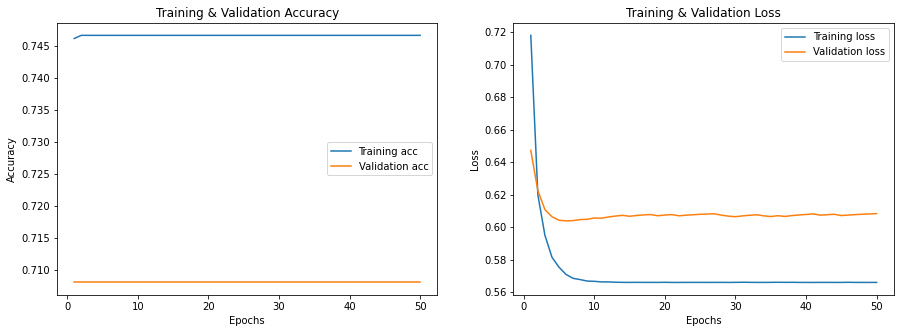

In [216]:
plot_training(baseline_dnn_history)

As expected, the dense neural network did not perform well, so I will move on to using the CNN architecture.

## CNN Model #1
For the first CNN model, a simple one convolutinal layer architecture is used.

In [43]:
cnn_model_1 = models.Sequential()
cnn_model_1.add(layers.Conv2D(8, (4, 4), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_1.add(layers.MaxPooling2D((2, 2)))

cnn_model_1.add(layers.Flatten())
cnn_model_1.add(layers.Dense(4, activation='relu'))
cnn_model_1.add(layers.Dense(1, activation='sigmoid'))

In [44]:
cnn_model_1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
cnn_history_1 = cnn_model_1.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 4s 207ms/step - loss: 0.7060 - accuracy: 0.6980 - val_loss: 0.6862 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 4s 200ms/step - loss: 0.6803 - accuracy: 0.7306 - val_loss: 0.6799 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 4s 201ms/step - loss: 0.6723 - accuracy: 0.7306 - val_loss: 0.6743 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 4s 213ms/step - loss: 0.6650 - accuracy: 0.7306 - val_loss: 0.6691 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 4s 214ms/step - loss: 0.6582 - accuracy: 0.7306 - val_loss: 0.6644 - val_accuracy: 0.6780
Epoch 6/30
18/18 [==============================] - 4s 208ms/step - loss: 0.6521 - accuracy: 0.7306 - val_loss: 0.6604 - val_accuracy: 0.6780
Epoch 7/30
18/18 [==============================] - 4s 204ms/step - loss: 0.6466 - accuracy: 0.7306 - val_loss: 0.6569 - val_accuracy: 0.6780
Epoch 

Final Training Accuracy: 0.7305606007575989
Final Validation Accuracy: 0.6779661178588867


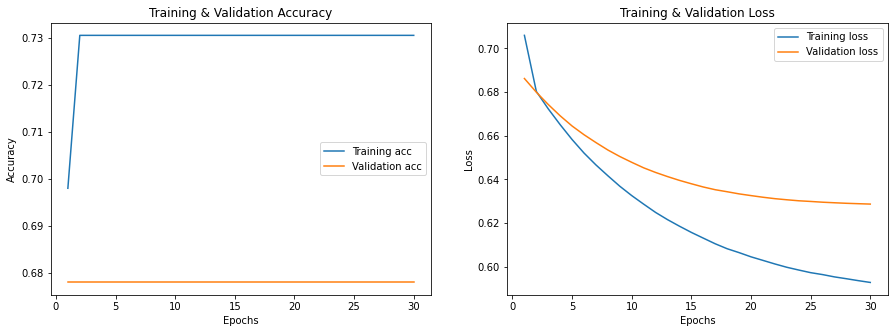

In [46]:
plot_training(cnn_history_1)

### CNN 2
The first CNN model was underfit to the data, so for this second model the architecture complexity is increased by adding a second convolutional layer and increasing the number of neurons in the dense layer.

In [55]:
cnn_model_2 = models.Sequential()
cnn_model_2.add(layers.Conv2D(8, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(20, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))

In [56]:
cnn_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
cnn_history_2 = cnn_model_2.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 5s 275ms/step - loss: 0.6375 - accuracy: 0.7197 - val_loss: 0.6423 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 5s 282ms/step - loss: 0.5740 - accuracy: 0.7306 - val_loss: 0.6356 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 5s 276ms/step - loss: 0.5644 - accuracy: 0.7306 - val_loss: 0.5839 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 5s 267ms/step - loss: 0.5436 - accuracy: 0.7306 - val_loss: 0.5804 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 5s 282ms/step - loss: 0.4917 - accuracy: 0.7306 - val_loss: 0.5048 - val_accuracy: 0.6780
Epoch 6/30
18/18 [==============================] - 5s 291ms/step - loss: 0.5038 - accuracy: 0.7306 - val_loss: 0.5244 - val_accuracy: 0.6780
Epoch 7/30
18/18 [==============================] - 5s 273ms/step - loss: 0.4787 - accuracy: 0.7306 - val_loss: 0.4536 - val_accuracy: 0.6780
Epoch 

Final Training Accuracy: 0.8770343661308289
Final Validation Accuracy: 0.8644067645072937


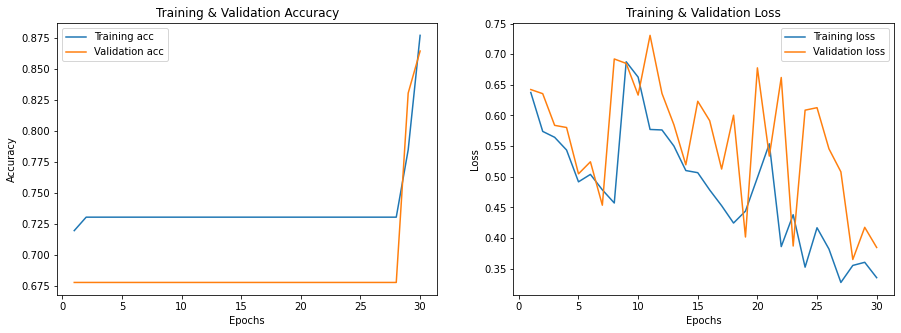

In [60]:
plot_training(cnn_history_2)

## CNN Model 3
The second model performed better, but is still underfit, so for the third model the architecture complexity is further increased to include more filters in the 2 convolutional layers and more neurons in the dense layer.

In [33]:
cnn_model_3 = models.Sequential()
cnn_model_3.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(50, activation='relu'))
cnn_model_3.add(layers.Dense(1, activation='sigmoid'))

In [34]:
cnn_model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
cnn_history_3 = cnn_model_3.fit(X_train_sub,
                    y_train_sub,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/30
18/18 [==============================] - 8s 471ms/step - loss: 0.6068 - accuracy: 0.7179 - val_loss: 0.6090 - val_accuracy: 0.6780
Epoch 2/30
18/18 [==============================] - 8s 445ms/step - loss: 0.5370 - accuracy: 0.7306 - val_loss: 0.5674 - val_accuracy: 0.6780
Epoch 3/30
18/18 [==============================] - 8s 463ms/step - loss: 0.5338 - accuracy: 0.7107 - val_loss: 0.5592 - val_accuracy: 0.6780
Epoch 4/30
18/18 [==============================] - 9s 483ms/step - loss: 0.5454 - accuracy: 0.7143 - val_loss: 0.5074 - val_accuracy: 0.6780
Epoch 5/30
18/18 [==============================] - 9s 522ms/step - loss: 0.4717 - accuracy: 0.7939 - val_loss: 0.4444 - val_accuracy: 0.8475
Epoch 6/30
18/18 [==============================] - 9s 507ms/step - loss: 0.4765 - accuracy: 0.7577 - val_loss: 0.4934 - val_accuracy: 0.7034
Epoch 7/30
18/18 [==============================] - 9s 476ms/step - loss: 0.4691 - accuracy: 0.7740 - val_loss: 0.3876 - val_accuracy: 0.8814
Epoch 

Final Training Accuracy: 0.9367088675498962
Final Validation Accuracy: 0.8728813529014587


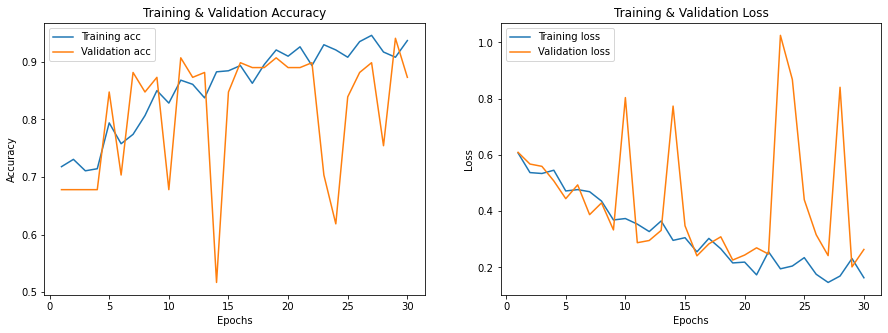

In [59]:
plot_training(cnn_history_3)

### CNN 4
The third model showed improvement in the training and validation accuracy, however, it is modestly overfit. Before applying regularization techniques, the epochs and batches hyperparameters are adjusted to see if the performance be be imporved further.

In [105]:
cnn_model_4 = models.Sequential()
cnn_model_4.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(50, activation='relu'))
cnn_model_4.add(layers.Dense(1, activation='sigmoid'))

In [106]:
cnn_model_4.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [107]:
cnn_history_4 = cnn_model_4.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 8s 903ms/step - loss: 0.6395 - accuracy: 0.6998 - val_loss: 0.6442 - val_accuracy: 0.7627
Epoch 2/100
9/9 [==============================] - 8s 854ms/step - loss: 0.5661 - accuracy: 0.7342 - val_loss: 0.5406 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 830ms/step - loss: 0.5417 - accuracy: 0.7342 - val_loss: 0.5166 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 7s 818ms/step - loss: 0.5029 - accuracy: 0.7577 - val_loss: 0.4888 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 8s 916ms/step - loss: 0.4778 - accuracy: 0.7830 - val_loss: 0.4649 - val_accuracy: 0.7458
Epoch 6/100
9/9 [==============================] - 8s 909ms/step - loss: 0.5378 - accuracy: 0.7758 - val_loss: 0.5062 - val_accuracy: 0.7373
Epoch 7/100
9/9 [==============================] - 8s 841ms/step - loss: 0.5302 - accuracy: 0.7848 - val_loss: 0.4258 - val_accuracy: 0.7712
Epoch 8/100
9

Epoch 59/100
9/9 [==============================] - 7s 813ms/step - loss: 0.1316 - accuracy: 0.9530 - val_loss: 0.1861 - val_accuracy: 0.9407
Epoch 60/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1317 - accuracy: 0.9458 - val_loss: 0.1888 - val_accuracy: 0.9407
Epoch 61/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1228 - accuracy: 0.9512 - val_loss: 0.1785 - val_accuracy: 0.9407
Epoch 62/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1297 - accuracy: 0.9512 - val_loss: 0.1770 - val_accuracy: 0.9407
Epoch 63/100
9/9 [==============================] - 7s 812ms/step - loss: 0.1298 - accuracy: 0.9494 - val_loss: 0.2216 - val_accuracy: 0.9153
Epoch 64/100
9/9 [==============================] - 7s 814ms/step - loss: 0.1558 - accuracy: 0.9403 - val_loss: 0.2223 - val_accuracy: 0.9153
Epoch 65/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1342 - accuracy: 0.9476 - val_loss: 0.2481 - val_accuracy: 0.9068
Epoch 

Final Training Accuracy: 0.9674502611160278
Final Validation Accuracy: 0.9067796468734741


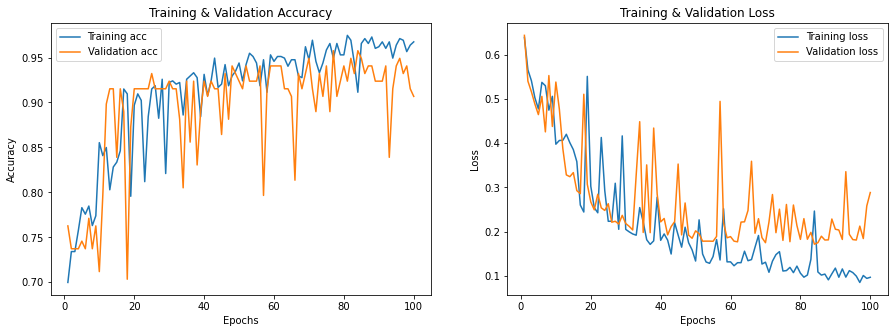

In [109]:
plot_training(cnn_history_4)

### CNN Model 5 - Dropout
The fourth model showed improved training accuracy, but is still overfit, so regularization techniques will be applied, starting with including a dropout rate.

In [110]:
cnn_model_5 = models.Sequential()
cnn_model_5.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))
cnn_model_5.add(layers.Dropout(0.3))

cnn_model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))
cnn_model_5.add(layers.Dropout(0.3))

cnn_model_5.add(layers.Flatten())
cnn_model_5.add(layers.Dense(50, activation='relu'))
cnn_model_5.add(layers.Dropout(0.3))
cnn_model_5.add(layers.Dense(1, activation='sigmoid'))

In [111]:
cnn_model_5.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:
cnn_history_5 = cnn_model_5.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 9s 1s/step - loss: 1.1801 - accuracy: 0.6691 - val_loss: 0.6567 - val_accuracy: 0.7373
Epoch 2/100
9/9 [==============================] - 9s 983ms/step - loss: 0.6022 - accuracy: 0.7269 - val_loss: 0.6452 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 9s 984ms/step - loss: 0.6080 - accuracy: 0.7269 - val_loss: 0.6396 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 9s 997ms/step - loss: 0.6020 - accuracy: 0.7306 - val_loss: 0.6271 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 9s 1s/step - loss: 0.5746 - accuracy: 0.7306 - val_loss: 0.6293 - val_accuracy: 0.7373
Epoch 6/100
9/9 [==============================] - 9s 985ms/step - loss: 0.5492 - accuracy: 0.7306 - val_loss: 0.6354 - val_accuracy: 0.7373
Epoch 7/100
9/9 [==============================] - 9s 967ms/step - loss: 0.5463 - accuracy: 0.7306 - val_loss: 0.5984 - val_accuracy: 0.7373
Epoch 8/100
9/9 [==

Epoch 59/100
9/9 [==============================] - 9s 968ms/step - loss: 0.2480 - accuracy: 0.9096 - val_loss: 0.3049 - val_accuracy: 0.8559
Epoch 60/100
9/9 [==============================] - 9s 961ms/step - loss: 0.2554 - accuracy: 0.9005 - val_loss: 0.3310 - val_accuracy: 0.9153
Epoch 61/100
9/9 [==============================] - 9s 970ms/step - loss: 0.2434 - accuracy: 0.9186 - val_loss: 0.3264 - val_accuracy: 0.8983
Epoch 62/100
9/9 [==============================] - 9s 973ms/step - loss: 0.2921 - accuracy: 0.8861 - val_loss: 0.2613 - val_accuracy: 0.9068
Epoch 63/100
9/9 [==============================] - 9s 972ms/step - loss: 0.2711 - accuracy: 0.8969 - val_loss: 0.3584 - val_accuracy: 0.8814
Epoch 64/100
9/9 [==============================] - 9s 964ms/step - loss: 0.2539 - accuracy: 0.9024 - val_loss: 0.4689 - val_accuracy: 0.7288
Epoch 65/100
9/9 [==============================] - 9s 961ms/step - loss: 0.2900 - accuracy: 0.8987 - val_loss: 0.2674 - val_accuracy: 0.8983
Epoch 

Final Training Accuracy: 0.9294756054878235
Final Validation Accuracy: 0.7796609997749329


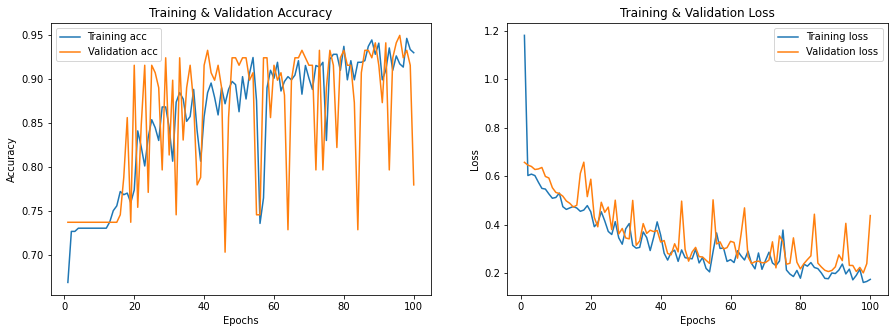

In [113]:
plot_training(cnn_history_5)

### CNN 6 - Regularizer
Including a dropout rate did not improve the model. As a next step a regularizer will be added to the convolutional layers.

In [114]:
cnn_model_6 = models.Sequential()
cnn_model_6.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.001),
                        input_shape=(256 ,256,  3)))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

cnn_model_6.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.001)))
cnn_model_6.add(layers.MaxPooling2D((2, 2)))

cnn_model_6.add(layers.Flatten())
cnn_model_6.add(layers.Dense(50, activation='relu'))
cnn_model_6.add(layers.Dense(1, activation='sigmoid'))

In [115]:
cnn_model_6.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [116]:
cnn_history_6 = cnn_model_6.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub))

Epoch 1/100
9/9 [==============================] - 7s 819ms/step - loss: 0.6503 - accuracy: 0.6655 - val_loss: 0.6637 - val_accuracy: 0.8898
Epoch 2/100
9/9 [==============================] - 7s 804ms/step - loss: 0.6265 - accuracy: 0.7541 - val_loss: 0.5531 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 804ms/step - loss: 0.5872 - accuracy: 0.7396 - val_loss: 0.6299 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 7s 807ms/step - loss: 0.5324 - accuracy: 0.7559 - val_loss: 0.6813 - val_accuracy: 0.5508
Epoch 5/100
9/9 [==============================] - 7s 804ms/step - loss: 0.5518 - accuracy: 0.7523 - val_loss: 0.4772 - val_accuracy: 0.7966
Epoch 6/100
9/9 [==============================] - 7s 810ms/step - loss: 0.5185 - accuracy: 0.7884 - val_loss: 0.4678 - val_accuracy: 0.7542
Epoch 7/100
9/9 [==============================] - 7s 804ms/step - loss: 0.4918 - accuracy: 0.7920 - val_loss: 0.5027 - val_accuracy: 0.7458
Epoch 8/100
9

Epoch 59/100
9/9 [==============================] - 7s 816ms/step - loss: 0.1440 - accuracy: 0.9620 - val_loss: 0.2847 - val_accuracy: 0.8983
Epoch 60/100
9/9 [==============================] - 7s 814ms/step - loss: 0.1893 - accuracy: 0.9349 - val_loss: 0.2090 - val_accuracy: 0.9322
Epoch 61/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1485 - accuracy: 0.9656 - val_loss: 0.2407 - val_accuracy: 0.9153
Epoch 62/100
9/9 [==============================] - 1287s 143s/step - loss: 0.1449 - accuracy: 0.9566 - val_loss: 0.2059 - val_accuracy: 0.9153
Epoch 63/100
9/9 [==============================] - 9s 949ms/step - loss: 0.1598 - accuracy: 0.9458 - val_loss: 0.2054 - val_accuracy: 0.9237
Epoch 64/100
9/9 [==============================] - 8s 919ms/step - loss: 0.1538 - accuracy: 0.9656 - val_loss: 0.2020 - val_accuracy: 0.9492
Epoch 65/100
9/9 [==============================] - 8s 904ms/step - loss: 0.1283 - accuracy: 0.9656 - val_loss: 0.4259 - val_accuracy: 0.8644
Epoc

Final Training Accuracy: 0.978300154209137
Final Validation Accuracy: 0.9406779408454895


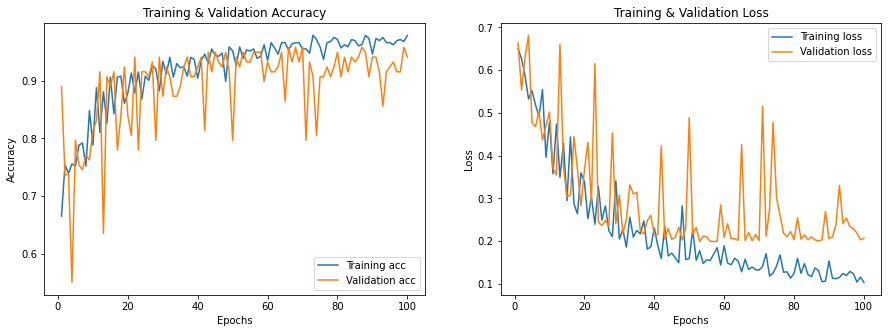

In [117]:
plot_training(cnn_history_6)

#### CNN 7 - Early Stopping
The regularizer model showed improved performance and reduced underfitting. Next, applying an early stopping method will be tried.

In [118]:
cnn_model_7 = models.Sequential()
cnn_model_7.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

cnn_model_7.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model_7.add(layers.MaxPooling2D((2, 2)))

cnn_model_7.add(layers.Flatten())
cnn_model_7.add(layers.Dense(50, activation='relu'))
cnn_model_7.add(layers.Dense(1, activation='sigmoid'))

In [119]:
cnn_model_7.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [120]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='cnn_model_7', monitor='val_loss', save_best_only=True)]

In [121]:
cnn_history_7 = cnn_model_7.fit(X_train_sub,
                    y_train_sub,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val_sub, y_val_sub),
                    callbacks=early_stopping)

Epoch 1/100
9/9 [==============================] - 9s 990ms/step - loss: 0.5925 - accuracy: 0.7306 - val_loss: 0.5562 - val_accuracy: 0.7373
Epoch 2/100
9/9 [==============================] - 8s 927ms/step - loss: 0.5849 - accuracy: 0.7306 - val_loss: 0.5362 - val_accuracy: 0.7373
Epoch 3/100
9/9 [==============================] - 7s 816ms/step - loss: 0.5567 - accuracy: 0.7523 - val_loss: 0.5725 - val_accuracy: 0.7373
Epoch 4/100
9/9 [==============================] - 8s 835ms/step - loss: 0.5252 - accuracy: 0.7486 - val_loss: 0.5385 - val_accuracy: 0.7373
Epoch 5/100
9/9 [==============================] - 8s 834ms/step - loss: 0.4651 - accuracy: 0.7722 - val_loss: 0.5779 - val_accuracy: 0.7373
Epoch 6/100
9/9 [==============================] - 9s 972ms/step - loss: 0.5193 - accuracy: 0.7957 - val_loss: 0.4380 - val_accuracy: 0.7627
Epoch 7/100
9/9 [==============================] - 7s 826ms/step - loss: 0.4890 - accuracy: 0.7812 - val_loss: 0.4450 - val_accuracy: 0.9068
Epoch 8/100
9

9/9 [==============================] - 8s 912ms/step - loss: 0.2329 - accuracy: 0.9132 - val_loss: 0.1775 - val_accuracy: 0.9492
Epoch 43/100
9/9 [==============================] - 7s 810ms/step - loss: 0.1272 - accuracy: 0.9566 - val_loss: 0.2302 - val_accuracy: 0.9068
Epoch 44/100
9/9 [==============================] - 7s 813ms/step - loss: 0.1402 - accuracy: 0.9512 - val_loss: 0.2166 - val_accuracy: 0.9068
Epoch 45/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1429 - accuracy: 0.9458 - val_loss: 0.1881 - val_accuracy: 0.9237
Epoch 46/100
9/9 [==============================] - 7s 815ms/step - loss: 0.1196 - accuracy: 0.9566 - val_loss: 0.1828 - val_accuracy: 0.9407
Epoch 47/100
9/9 [==============================] - 8s 936ms/step - loss: 0.1794 - accuracy: 0.9403 - val_loss: 0.1709 - val_accuracy: 0.9407
Epoch 48/100
9/9 [==============================] - 7s 819ms/step - loss: 0.1230 - accuracy: 0.9602 - val_loss: 0.1762 - val_accuracy: 0.9407
Epoch 49/100
9/9 [=

In [122]:
# Load the best (saved) model
saved_model = load_model('cnn_model_7')

In [123]:
saved_model.evaluate(X_train_sub_2, y_train_sub_2)

18/18 [==============================] - 2s 84ms/step - loss: 0.0951 - accuracy: 0.9747


[0.095072902739048, 0.9746835231781006]

In [124]:
saved_model.evaluate(X_val_sub_2, y_val_sub_2)

4/4 [==============================] - 0s 63ms/step - loss: 0.1642 - accuracy: 0.9576


[0.1641789823770523, 0.9576271176338196]

The early stopping model produced a similar training accuracy to the regularized model, with slightly less overfitting, therfore this model will be selected as the final model and trained on the entirety of the training data.

## Final Model Evaluation

In [127]:
final_model = models.Sequential()
final_model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(256 ,256,  3)))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Flatten())
final_model.add(layers.Dense(50, activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

In [128]:
final_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [129]:
# Define the callbacks
final_early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='final_model', monitor='val_loss', save_best_only=True)]

In [130]:
final_model_history = final_model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=final_early_stopping)

Epoch 1/100
65/65 [==============================] - 106s 2s/step - loss: 0.5735 - accuracy: 0.7211 - val_loss: 0.9239 - val_accuracy: 0.2787
Epoch 2/100
65/65 [==============================] - 59s 915ms/step - loss: 0.4795 - accuracy: 0.7543 - val_loss: 0.9799 - val_accuracy: 0.7213
Epoch 3/100
65/65 [==============================] - 60s 930ms/step - loss: 0.4329 - accuracy: 0.8070 - val_loss: 0.4540 - val_accuracy: 0.7645
Epoch 4/100
65/65 [==============================] - 62s 956ms/step - loss: 0.3465 - accuracy: 0.8536 - val_loss: 1.0072 - val_accuracy: 0.7258
Epoch 5/100
65/65 [==============================] - 61s 934ms/step - loss: 0.3078 - accuracy: 0.8824 - val_loss: 1.3122 - val_accuracy: 0.3993
Epoch 6/100
65/65 [==============================] - 59s 911ms/step - loss: 0.2732 - accuracy: 0.8882 - val_loss: 0.6469 - val_accuracy: 0.6917
Epoch 7/100
65/65 [==============================] - 59s 910ms/step - loss: 0.2633 - accuracy: 0.8929 - val_loss: 0.7117 - val_accuracy: 0

65/65 [==============================] - 60s 922ms/step - loss: 0.1270 - accuracy: 0.9531 - val_loss: 0.1383 - val_accuracy: 0.9556
Epoch 47/100
65/65 [==============================] - 60s 921ms/step - loss: 0.1160 - accuracy: 0.9583 - val_loss: 0.1399 - val_accuracy: 0.9545
Epoch 48/100
65/65 [==============================] - 60s 928ms/step - loss: 0.1172 - accuracy: 0.9578 - val_loss: 2.7923 - val_accuracy: 0.4266
Epoch 49/100
65/65 [==============================] - 60s 927ms/step - loss: 0.1676 - accuracy: 0.9431 - val_loss: 0.1954 - val_accuracy: 0.9306
Epoch 50/100
65/65 [==============================] - 60s 924ms/step - loss: 0.1163 - accuracy: 0.9583 - val_loss: 0.1447 - val_accuracy: 0.9511
Epoch 51/100
65/65 [==============================] - 61s 934ms/step - loss: 0.1083 - accuracy: 0.9605 - val_loss: 0.8049 - val_accuracy: 0.7133
Epoch 52/100
65/65 [==============================] - 61s 941ms/step - loss: 0.1266 - accuracy: 0.9536 - val_loss: 0.2038 - val_accuracy: 0.929

In [131]:
# Load the best (saved) model
final_saved_model = load_model('final_model')

In [132]:
final_saved_model.evaluate(X_train, y_train)

129/129 [==============================] - 12s 97ms/step - loss: 0.1114 - accuracy: 0.9624


[0.11135528236627579, 0.9624207019805908]

In [133]:
final_saved_model.evaluate(X_val, y_val)

28/28 [==============================] - 3s 90ms/step - loss: 0.1382 - accuracy: 0.9556


[0.1381685882806778, 0.9556313753128052]

In [134]:
final_saved_model.evaluate(X_test, y_test)

28/28 [==============================] - 3s 102ms/step - loss: 0.1278 - accuracy: 0.9465


[0.12779143452644348, 0.9465301632881165]

### Visualizing Intermediates

In [167]:
model = final_saved_model

In [168]:
train_images[0].shape

(256, 256, 3)

(1, 256, 256, 3)


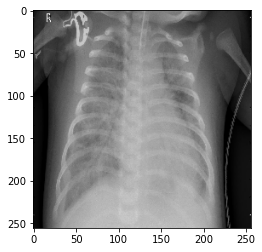

In [169]:
#Load image from training set
img_path = 'chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'


img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [170]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

(1, 254, 254, 16)


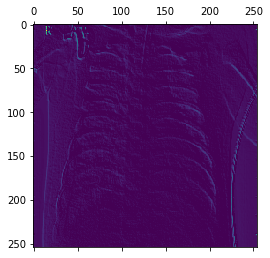

In [171]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

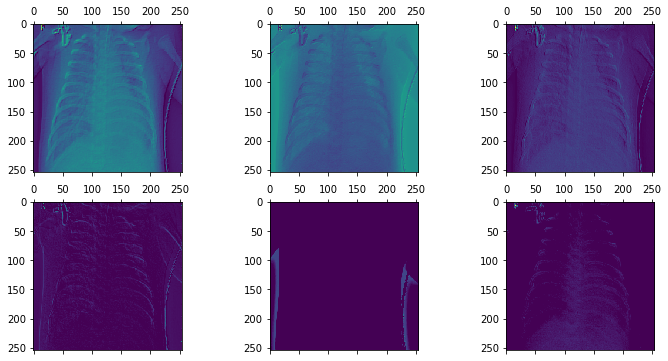

In [172]:
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i in range(6):
    row = i//3
    column = i%3
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

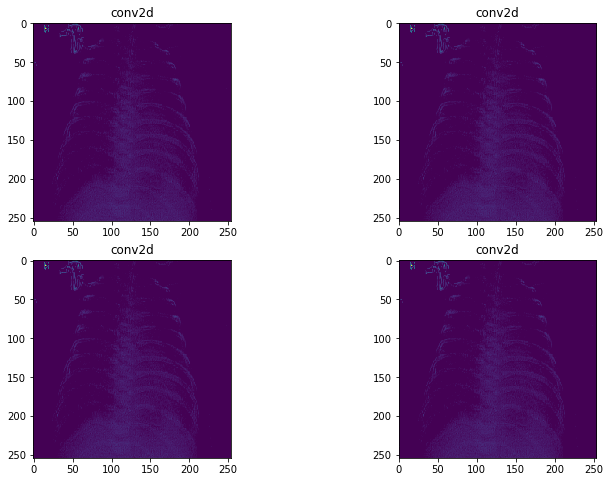

In [183]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

for i in range(4):
    row = i//2
    column = i%2
    ax = axes[row, column]
    cur_layer = activations[0]
    ax.matshow(cur_layer[0, :, :, 5], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[0])

### Lime

In [174]:
explainer = lime_image.LimeImageExplainer()

In [175]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img_tensor[0].astype('double'), model.predict, top_labels=2, hide_color=0, num_samples=1000)


Wall time: 10.4 s


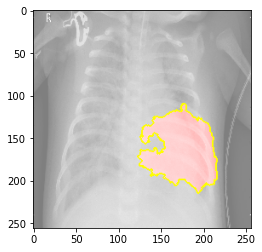

In [180]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

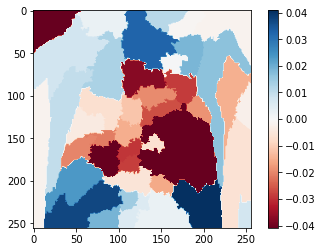

In [119]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Conclusion

## Next Steps